# AIM0403D2203 Text Classification (Machine Learning)
---
Hari ini, kita akan menyelesaikan kasus klasifikasi SMS spam menggunakan skema seperti gambar di bawah ini.

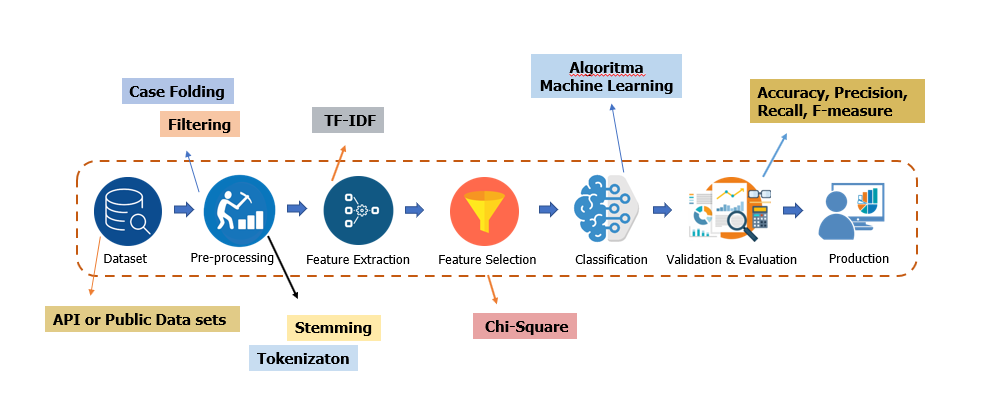

Langkah-langkah penyelesaian meliputi:
1. Data Acquisition
2. Text Pre-processing
   1. Case Folding
   2. Filtering
   3. Stopword
   4. Stemming
3. Feature Engineering
   1. Feature Extraction - BoW & TF IDF
   2. Feature Selection - Chi-Square
4. Modelling (Machine Learning)
5. Model Evaluation
6. Deployment


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Untuk mempermudah, simpan setiap objek agar dapat digunakan untuk pemodelan maupun deployment. Gunakan library Pickle
import pickle

%matplotlib inline

In [2]:
# Install library Sastrawi
!pip -q install sastrawi

In [3]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# 01 Data Acquisition

Penjelasan Polaritas Sentiment 
* -1: negatif
* 1: positif 

In [4]:
# Download dataset
!wget https://raw.githubusercontent.com/rizalespe/Dataset-Sentimen-Analisis-Bahasa-Indonesia/master/dataset_tweet_sentiment_opini_film.csv

--2022-10-06 16:27:05--  https://raw.githubusercontent.com/rizalespe/Dataset-Sentimen-Analisis-Bahasa-Indonesia/master/dataset_tweet_sentiment_opini_film.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 22687 (22K) [text/plain]
Saving to: ‘dataset_tweet_sentiment_opini_film.csv.3’

dataset_tweet_senti 100%[===================>]  22.16K  --.-KB/s    in 0.002s  

2022-10-06 16:27:05 (14.4 MB/s) - ‘dataset_tweet_sentiment_opini_film.csv.3’ saved [22687/22687]



In [5]:
dataset_sentimen = pd.read_csv('dataset_tweet_sentiment_opini_film.csv')
dataset_sentimen.head()

,Id,Sentiment,Text Tweet
0,1,negative,Jelek filmnya... apalagi si ernest gak mutu bg...
1,2,negative,Film king Arthur ini film paling jelek dari se...
2,3,negative,@beexkuanlin Sepanjang film gwa berkata kasar ...
3,4,negative,Ane ga suka fast and furious..menurutku kok je...
4,5,negative,"@baekhyun36 kan gua ga tau film nya, lu bilang..."


In [6]:
dataset_sentimen.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Id          200 non-null    int64 
 1   Sentiment   200 non-null    object
 2   Text Tweet  200 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.8+ KB


In [7]:
dataset_sentimen.drop(dataset_sentimen.columns[[0]], axis = 1, inplace = True)

In [8]:
def polaritas(teks):
  if teks =='positive':
    return 1
  elif teks =='negative':
    return -1

In [9]:
dataset_sentimen['label'] = dataset_sentimen['Sentiment'].apply(polaritas)

In [10]:
dataset_sentimen

,Sentiment,Text Tweet,label
0,negative,Jelek filmnya... apalagi si ernest gak mutu bg...,-1
1,negative,Film king Arthur ini film paling jelek dari se...,-1
2,negative,@beexkuanlin Sepanjang film gwa berkata kasar ...,-1
3,negative,Ane ga suka fast and furious..menurutku kok je...,-1
4,negative,"@baekhyun36 kan gua ga tau film nya, lu bilang...",-1
...,...,...,...
195,positive,Fargo juga adaptasi dari film yang cukup berha...,1
196,positive,637.000 waw ini sangat keren flm horor dng jum...,1
197,positive,@filmziarah film yang tenang dan menghanyutkan...,1
198,positive,Film yg amat menarik. Kisah cinta & kesetiaan ...,1


In [11]:
print('Total Jumlah Tweet:', dataset_sentimen.shape[0], 'dataset_sentimen\n')
print('terdiri dari (label):')
print('-- [-1] Negatif\t\t:', dataset_sentimen[dataset_sentimen.label == -1].shape[0], 'dataset')
print('-- [1] Positif\t\t:', dataset_sentimen[dataset_sentimen.label == 1].shape[0], 'dataset\n')

Total Jumlah Tweet: 200 dataset_sentimen

terdiri dari (label):
-- [-1] Negatif		: 100 dataset
-- [1] Positif		: 100 dataset



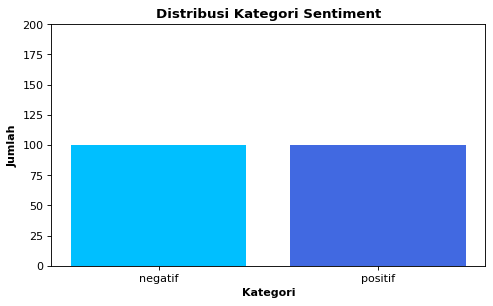

In [12]:
height = dataset_sentimen['label'].value_counts()
labels = ('negatif', 'positif')
y_pos = np.arange(len(labels))

plt.figure(figsize=(7,4), dpi=80)
plt.ylim(0,200)
plt.title('Distribusi Kategori Sentiment', fontweight='bold')
plt.xlabel('Kategori', fontweight='bold')
plt.ylabel('Jumlah', fontweight='bold')
plt.bar(y_pos, height, color=['deepskyblue', 'royalblue', 'skyblue'])
plt.xticks(y_pos, labels)
plt.show()

# 02 Text Preprocessing

## Case Folding

In [13]:
import re

# Buat fungsi untuk langkah case folding
def casefolding(text):
  text = text.lower()                               # Mengubah teks menjadi lower case
  text = re.sub(r'https?://\S+|www\.\S+', '', text) # Menghapus URL
  text = re.sub(r'[-+]?[0-9]+', '', text)           # Menghapus angka
  text = re.sub(r'[^\w\s]','', text)                # Menghapus karakter tanda baca
  text = text.strip()
  return text

In [14]:
raw_sample = dataset_sentimen['Text Tweet'].iloc[100]
case_folding = casefolding(raw_sample)

print('Raw data\t: ', raw_sample)
print('Case folding\t: ', case_folding)

Raw data	:  Keren bang flm lo @radityadika persahabatan, keluarga dan cinta kentel banget. Tokoh pemain pas semua keren bang
Case folding	:  keren bang flm lo radityadika persahabatan keluarga dan cinta kentel banget tokoh pemain pas semua keren bang


## Word Normalization

In [15]:
# Download corpus kumpulan slangwords
!wget https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/key_norm.csv

--2022-10-06 16:27:06--  https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/data/key_norm.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80969 (79K) [text/plain]
Saving to: ‘key_norm.csv.3’

key_norm.csv.3      100%[===================>]  79.07K  --.-KB/s    in 0.01s   

2022-10-06 16:27:06 (5.98 MB/s) - ‘key_norm.csv.3’ saved [80969/80969]



In [16]:
key_norm = pd.read_csv('key_norm.csv')
print(key_norm.head())

key_norm.shape

   _id      singkat       hasil
0    1         abis       habis
1    2       accent     tekanan
2    3       accept      terima
3    4     accident  kecelakaan
4    5  achievement    prestasi


(3720, 3)

In [17]:
def text_normalize(text):
  text = ' '.join([key_norm[key_norm['singkat'] == word]['hasil'].values[0] if (key_norm['singkat'] == word).any() else word for word in text.split()])
  text = str.lower(text)
  return text

## Filtering (Stopword Removal)

In [18]:
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

stopwords_ind = stopwords.words('indonesian')

In [19]:
len(stopwords_ind)

758

In [20]:
# Lihat daftar stopword yang disediakan NLTK
stopwords_ind[:20]

['ada',
 'adalah',
 'adanya',
 'adapun',
 'agak',
 'agaknya',
 'agar',
 'akan',
 'akankah',
 'akhir',
 'akhiri',
 'akhirnya',
 'aku',
 'akulah',
 'amat',
 'amatlah',
 'anda',
 'andalah',
 'antar',
 'antara']

In [21]:
# Buat fungsi untuk langkah stopword removal

more_stopword = ['banget', 'habis', 'bikin', 'sih']                    # Tambahkan kata lain dalam daftar stopword
stopwords_ind = stopwords_ind + more_stopword

def remove_stop_words(text):
  clean_words = []
  text = text.split()
  for word in text:
      if word not in stopwords_ind:
          clean_words.append(word)
  return " ".join(clean_words)

In [22]:
raw_sample = dataset_sentimen['Text Tweet'].iloc[100]
case_folding = casefolding(raw_sample)
stopword_removal = remove_stop_words(case_folding)

print('Raw data\t\t: ', raw_sample)
print('Case folding\t\t: ', case_folding)
print('Stopword removal\t: ', stopword_removal)

Raw data		:  Keren bang flm lo @radityadika persahabatan, keluarga dan cinta kentel banget. Tokoh pemain pas semua keren bang
Case folding		:  keren bang flm lo radityadika persahabatan keluarga dan cinta kentel banget tokoh pemain pas semua keren bang
Stopword removal	:  keren bang flm lo radityadika persahabatan keluarga cinta kentel tokoh pemain pas keren bang


## Stemming

In [23]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Buat fungsi untuk langkah stemming bahasa Indonesia
def stemming(text):
  text = stemmer.stem(text)
  return text

In [24]:
raw_sample = dataset_sentimen['Text Tweet'].iloc[100]
case_folding = casefolding(raw_sample)
stopword_removal = remove_stop_words(case_folding)
text_stemming = stemming(stopword_removal)

print('Raw data\t\t: ', raw_sample)
print('Case folding\t\t: ', case_folding)
print('Stopword removal\t: ', stopword_removal)
print('Stemming\t\t: ', text_stemming)

Raw data		:  Keren bang flm lo @radityadika persahabatan, keluarga dan cinta kentel banget. Tokoh pemain pas semua keren bang
Case folding		:  keren bang flm lo radityadika persahabatan keluarga dan cinta kentel banget tokoh pemain pas semua keren bang
Stopword removal	:  keren bang flm lo radityadika persahabatan keluarga cinta kentel tokoh pemain pas keren bang
Stemming		:  keren bang flm lo radityadika sahabat keluarga cinta kentel tokoh main pas keren bang


In [25]:
def remove_emoji(string):
  emoji_pattern = re.compile(
      "["
      u"\U0001F600-\U0001F64F" #emoticon
      u"\U0001F300-\U0001F5FF" #symbols and pictographs
      u"\U0001F1E0-\U0001F1FF" #flags(ios)
      u"\U00002702-\U000027B0"
      u"\U000024C2-\U0001F251"  
      "]+",
      flags=re.UNICODE,
  )
  return emoji_pattern.sub(r"",string)

## Text Preprocessing Pipeline

In [26]:
# Buat fungsi untuk menggabungkan seluruh langkah text preprocessing
def text_preprocessing_process(text):
  text = casefolding(text)
  text = text_normalize(text)
  text = remove_stop_words(text)
  text = stemming(text)
  text = remove_emoji(text)
  return text

In [27]:
%%time
dataset_sentimen['text_tweet_bersih'] = dataset_sentimen['Text Tweet'].apply(text_preprocessing_process)

# Perhatikan waktu komputasi ketika proses text preprocessing

CPU times: user 1min 9s, sys: 288 ms, total: 1min 9s
Wall time: 1min 17s


In [28]:
dataset_sentimen

,Sentiment,Text Tweet,label,text_tweet_bersih
0,negative,Jelek filmnya... apalagi si ernest gak mutu bg...,-1,jelek film si ernest mutu actingnya film sampah
1,negative,Film king Arthur ini film paling jelek dari se...,-1,film king arthur film jelek cerita king arthur
2,negative,@beexkuanlin Sepanjang film gwa berkata kasar ...,-1,beexkuanlin film gwa kasar bapak
3,negative,Ane ga suka fast and furious..menurutku kok je...,-1,suka fast and furiousmenurutku jelek ya film
4,negative,"@baekhyun36 kan gua ga tau film nya, lu bilang...",-1,baekhyun tau film nya bilang perang perang per...
...,...,...,...,...
195,positive,Fargo juga adaptasi dari film yang cukup berha...,1,fargo adaptasi film hasil season nya the best
196,positive,637.000 waw ini sangat keren flm horor dng jum...,1,waw keren flm horor tonton gin prillybie danur...
197,positive,@filmziarah film yang tenang dan menghanyutkan...,1,filmziarah film tenang hanyut salut mbah ponco...
198,positive,Film yg amat menarik. Kisah cinta & kesetiaan ...,1,film tarik kisah cinta setia saji kangen nenek...


In [29]:
# Simpan data yang telah melalui text preprocessing agar kita tidak perlu menjalankan proses tersebut mulai awal (Opsional)
# data.to_csv('clean_data.csv')

# 03 Feature Engineering

In [30]:
# Pisahkan kolom fitur dan target
X = dataset_sentimen['text_tweet_bersih']
y = dataset_sentimen['Sentiment']

In [31]:
X

0        jelek film si ernest mutu actingnya film sampah
1         film king arthur film jelek cerita king arthur
2                       beexkuanlin film gwa kasar bapak
3           suka fast and furiousmenurutku jelek ya film
4      baekhyun tau film nya bilang perang perang per...
                             ...                        
195        fargo adaptasi film hasil season nya the best
196    waw keren flm horor tonton gin prillybie danur...
197    filmziarah film tenang hanyut salut mbah ponco...
198    film tarik kisah cinta setia saji kangen nenek...
199    nntn filmziarah film bagus kali menit tonton a...
Name: text_tweet_bersih, Length: 200, dtype: object

In [32]:
y

0      negative
1      negative
2      negative
3      negative
4      negative
         ...   
195    positive
196    positive
197    positive
198    positive
199    positive
Name: Sentiment, Length: 200, dtype: object

## Feature Extraction (TF-IDF & N-Gram)
Proses mengubah teks menjadi vector menggunakan metode TF-IDF

In [33]:
'''
Convert a collection of raw documents to a matrix of TF-IDF features
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html
'''
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer(ngram_range=(1,1))
tf_idf.fit(X)

TfidfVectorizer()

In [34]:
# Melihat Jumlah Fitur
print(len(tf_idf.get_feature_names_out()))

766


In [35]:
# Melihat fitur-fitur apa saja yang ada di dalam corpus
print(tf_idf.get_feature_names_out())

['abiss' 'acclaim' 'actingnya' 'adaptasi' 'adegan' 'aduh' 'aduk' 'agam'
 'agama' 'ah' 'air' 'ajaa' 'ajak' 'ajar' 'akan' 'akhrnya' 'aksi' 'akting'
 'aktor' 'aktris' 'ale' 'alf' 'alien' 'alitalit' 'alur' 'amat' 'ambigu'
 'amira' 'anak' 'and' 'andibowooo' 'aneh' 'angkat' 'anjak' 'anjlok' 'anya'
 'apresiasi' 'april' 'arah' 'arthur' 'artis' 'asih' 'asik' 'askmenfess'
 'asli' 'astagah' 'aurat' 'awisuryadi' 'baca' 'baekhyun' 'bagus'
 'baguskelompoknya' 'bagussss' 'bahagia' 'bahas' 'bahasa' 'baik' 'baja'
 'balap' 'balik' 'banding' 'bandung' 'bang' 'bangat' 'bangetbuat'
 'bangetkalian' 'bangettt' 'bangga' 'banggafilmindonesia' 'bangsa' 'bangt'
 'banyak' 'bapak' 'bareng' 'baru' 'barusan' 'batal' 'batas' 'bawa' 'bawah'
 'bayang' 'bayar' 'bebas' 'beda' 'beexkuanlin' 'begadang' 'belah' 'belang'
 'benar' 'bener' 'benerbener' 'benerseru' 'bentar' 'berat' 'berbudget'
 'berekspektasi' 'berfikir' 'berkalikali' 'best' 'besut' 'betapa' 'bewe'
 'bg' 'bgni' 'bgussayangnya' 'bhineka' 'biasapemikiran' 'bikin'

In [36]:
# Melihat matriks jumlah token
# Data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

X_tf_idf = tf_idf.transform(X).toarray()
X_tf_idf

array([[0.        , 0.        , 0.43767971, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [37]:
# Melihat matriks jumlah token menggunakan TF IDF, lihat perbedaannya dengan metode BoW
# Data ini siap untuk dimasukkan dalam proses pemodelan (machine learning)

data_tf_idf = pd.DataFrame(X_tf_idf, columns=tf_idf.get_feature_names_out())
data_tf_idf

,abiss,acclaim,actingnya,adaptasi,adegan,aduh,aduk,agam,agama,ah,...,wkwk,wonder,worth,ya,yah,yanskii,yaoi,youtube,yuk,ziarah
0,0.0,0.0,0.43768,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.319106,0.0,0.0,0.000000,0.0,0.0,0.0
4,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.259967,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.0,0.0,0.00000,0.37323,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
196,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
197,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0
198,0.0,0.0,0.00000,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0


In [38]:
with open('tf_idf_feature.pickle', 'wb') as output:
  pickle.dump(X_tf_idf, output)

## Feature Selection (Chi Square)

In [39]:
# Mengubah nilai data tabular tf-idf menjadi array agar dapat dijalankan pada proses seleksi fitur
X = np.array(data_tf_idf)
y = np.array(y)

In [40]:
'''
Select features according to the k highest scores.
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html

Compute chi-squared stats between each non-negative feature and class.
https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.chi2.html
'''

from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import chi2 

# Ten features with highest chi-squared statistics are selected 
chi2_features = SelectKBest(chi2, k=200) 
X_kbest_features = chi2_features.fit_transform(X, y) 
  
# Reduced features 
print('Original feature number:', X.shape[1]) 
print('Reduced feature number:', X_kbest_features.shape[1]) 

Original feature number: 766
Reduced feature number: 200


In [41]:
# chi2_features.scores_ adalah nilai chi-square, semakin tinggi nilainya maka semakin baik fiturnya
data_chi2 = pd.DataFrame(chi2_features.scores_, columns=['nilai'])
data_chi2

,nilai
0,0.247537
1,0.379005
2,0.437680
3,0.242692
4,0.597267
...,...
761,0.649226
762,0.259967
763,0.414480
764,0.355231


In [42]:
# Menampilkan fitur beserta nilainya
feature = tf_idf.get_feature_names_out()
data_chi2['fitur'] = feature
data_chi2

,nilai,fitur
0,0.247537,abiss
1,0.379005,acclaim
2,0.437680,actingnya
3,0.242692,adaptasi
4,0.597267,adegan
...,...,...
761,0.649226,yanskii
762,0.259967,yaoi
763,0.414480,youtube
764,0.355231,yuk


In [43]:
# Mengurutkan fitur terbaik
data_chi2.sort_values(by='nilai', ascending=False)

,nilai,fitur
353,5.964537e+00,kecewa
318,5.466402e+00,jelek
364,4.977579e+00,keren
265,3.100242e+00,hambar
464,2.438656e+00,mummy
...,...,...
71,6.559880e-04,banyak
389,5.147805e-04,langsung
359,5.111505e-04,kemarin
537,7.080290e-05,percaya


In [44]:
# Menampilkan mask pada feature yang diseleksi
# False berarti fitur tidak terpilih dan True berarti fitur terpilih
mask = chi2_features.get_support()
mask

array([False, False, False, False,  True,  True, False, False, False,
       False, False,  True, False, False, False, False, False, False,
        True, False,  True, False,  True, False, False, False, False,
       False, False, False, False,  True,  True, False,  True,  True,
        True, False, False,  True, False, False,  True, False,  True,
        True, False, False, False, False,  True,  True,  True,  True,
        True, False,  True, False, False, False,  True, False,  True,
       False, False, False,  True,  True,  True, False, False, False,
        True, False, False,  True, False, False, False, False, False,
       False, False, False,  True, False,  True, False, False, False,
       False, False,  True, False, False,  True,  True, False, False,
       False, False, False, False,  True, False, False, False,  True,
        True,  True, False, False, False,  True, False, False, False,
       False, False,  True, False,  True,  True, False, False, False,
       False, False,

In [45]:
# Menampilkan fitur-fitur terpilih berdasarkan mask atau nilai tertinggi yang sudah dikalkulasi pada Chi-Square
new_feature = []

for bool, f in zip(mask, feature):
  if bool:
    new_feature.append(f)
  selected_feature = new_feature

selected_feature

['adegan',
 'aduh',
 'ajaa',
 'aktor',
 'ale',
 'alien',
 'aneh',
 'angkat',
 'anjlok',
 'anya',
 'apresiasi',
 'arthur',
 'asik',
 'asli',
 'astagah',
 'bagus',
 'baguskelompoknya',
 'bagussss',
 'bahagia',
 'bahas',
 'baik',
 'banding',
 'bang',
 'bangettt',
 'bangga',
 'banggafilmindonesia',
 'bapak',
 'barusan',
 'beexkuanlin',
 'belah',
 'bentar',
 'berekspektasi',
 'berfikir',
 'bgni',
 'bikin',
 'bilang',
 'bingittsss',
 'bkin',
 'bodoh',
 'bosan',
 'bosen',
 'busuk',
 'catat',
 'cek',
 'cenayangfilm',
 'cinta',
 'coba',
 'cocok',
 'dada',
 'danurmovie',
 'dapat',
 'dapet',
 'deh',
 'derita',
 'dhikefact',
 'divergent',
 'download',
 'dramatis',
 'duh',
 'ending',
 'epic',
 'erti',
 'falsafah',
 'filmkartini',
 'filmziarah',
 'gegara',
 'gembira',
 'generasi',
 'get',
 'getout',
 'getoutmovie',
 'gokil',
 'guru',
 'guys',
 'gwa',
 'hambar',
 'hambarr',
 'hancur',
 'hanungbramantyo',
 'harga',
 'haruuuu',
 'hasil',
 'homo',
 'horor',
 'horror',
 'indonesia',
 'inspirasi',
 'isi',

In [46]:
# Cara melihat vocab yang dihasilkan oleh TF_IDF
# tf_idf.vocabulary_ 

kbest_feature = {} # Buat dictionary kosong

for (k,v) in tf_idf.vocabulary_.items():    # Iterasi untuk mengulangi vocab yang dihasilkan TF_IDF
  if k in selected_feature:                 # Cek apakah fitur termasuk k fitur yang diseleksi
    kbest_feature[k] = v                    # Jika iya, simpan fitur tersebut pada dictionary kosong diatas

In [47]:
kbest_feature

{'jelek': 318,
 'si': 640,
 'mutu': 466,
 'king': 371,
 'arthur': 39,
 'beexkuanlin': 84,
 'gwa': 263,
 'kasar': 345,
 'bapak': 72,
 'bilang': 108,
 'perang': 536,
 'bagus': 50,
 'kecewa': 353,
 'indonesia': 295,
 'salah': 600,
 'aktor': 18,
 'tonton': 724,
 'guys': 262,
 'radityadika': 566,
 'sorry': 653,
 'yah': 760,
 'berekspektasi': 95,
 'isi': 307,
 'kartini': 343,
 'ale': 20,
 'anya': 35,
 'jaman': 315,
 'bodoh': 119,
 'ngomong': 482,
 'singkat': 644,
 'banding': 60,
 'anjlok': 34,
 'alien': 22,
 'ragu': 567,
 'satusatunya': 608,
 'rugi': 590,
 'baguskelompoknya': 51,
 'kasih': 346,
 'harga': 275,
 'duh': 192,
 'ribet': 581,
 'adegan': 4,
 'potong': 552,
 'rusak': 594,
 'ogah': 508,
 'bahas': 54,
 'angkat': 32,
 'novel': 497,
 'oke': 509,
 'bosan': 121,
 'mummy': 464,
 'aneh': 31,
 'norak': 496,
 'laku': 388,
 'hambar': 265,
 'cinta': 153,
 'homo': 284,
 'rumit': 592,
 'derita': 176,
 'sesal': 634,
 'download': 187,
 'hasil': 277,
 'berfikir': 96,
 'kaya': 352,
 'mati': 431,
 'ti

In [48]:
# Menampilkan fitur-fitur yang sudah diseleksi 
# Beserta nilai vektornya pada keseluruhan data untuk dijalankan pada proses machine learning

# Hanya k fitur yang terpilih sesuai parameter k yang ditentukan sebelumnya

data_selected_feature = pd.DataFrame(X_kbest_features, columns=selected_feature)
data_selected_feature

,adegan,aduh,ajaa,aktor,ale,alien,aneh,angkat,anjlok,anya,...,tidur,tonton,umur,unaazizah,vlog,wajib,wkwk,yah,yanskii,ziarah
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
196,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.210771,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
197,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
198,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
with open('kbest_feature.pickle', 'wb') as output:
  pickle.dump(kbest_feature, output)

# 04 Modelling (Machine Learning)

#Gaussian VS Lexicon Based

In [50]:
dataset_sentimen['text_tweet_bersih'] = dataset_sentimen['Text Tweet'].apply(text_preprocessing_process)

In [51]:
dataset_sentimen

,Sentiment,Text Tweet,label,text_tweet_bersih
0,negative,Jelek filmnya... apalagi si ernest gak mutu bg...,-1,jelek film si ernest mutu actingnya film sampah
1,negative,Film king Arthur ini film paling jelek dari se...,-1,film king arthur film jelek cerita king arthur
2,negative,@beexkuanlin Sepanjang film gwa berkata kasar ...,-1,beexkuanlin film gwa kasar bapak
3,negative,Ane ga suka fast and furious..menurutku kok je...,-1,suka fast and furiousmenurutku jelek ya film
4,negative,"@baekhyun36 kan gua ga tau film nya, lu bilang...",-1,baekhyun tau film nya bilang perang perang per...
...,...,...,...,...
195,positive,Fargo juga adaptasi dari film yang cukup berha...,1,fargo adaptasi film hasil season nya the best
196,positive,637.000 waw ini sangat keren flm horor dng jum...,1,waw keren flm horor tonton gin prillybie danur...
197,positive,@filmziarah film yang tenang dan menghanyutkan...,1,filmziarah film tenang hanyut salut mbah ponco...
198,positive,Film yg amat menarik. Kisah cinta & kesetiaan ...,1,film tarik kisah cinta setia saji kangen nenek...


In [52]:
##load data
!git clone https://github.com/fajri91/InSet.git

fatal: destination path 'InSet' already exists and is not an empty directory.


In [53]:
negative_word = pd.read_csv('/content/InSet/negative.tsv', delimiter="\t")
positive_word = pd.read_csv('/content/InSet/positive.tsv', delimiter="\t")

In [54]:
# concatenating 2 dataframe
vertical_concat = pd.concat([negative_word, positive_word], axis=0)

In [55]:
#vertical_concat.to_csv('/content/drive/MyDrive/PIL/XLNET/kamus_inset_lexicon.csv',index=False)

In [56]:
inset_lexicon = vertical_concat
inset_lexicon

,word,weight
0,putus tali gantung,-2
1,gelebah,-2
2,gobar hati,-2
3,tersentuh (perasaan),-1
4,isak,-5
...,...,...
3604,melarikan,3
3605,vakansi,3
3606,spesial,4
3607,asrama,3


In [57]:
inset_lexicon.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10218 entries, 0 to 3608
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   word    10218 non-null  object
 1   weight  10218 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 239.5+ KB


In [58]:
#ubah ke dictionary
kamus_inset_lexicon = dict(zip(inset_lexicon.word, inset_lexicon.weight))

In [59]:
kamus_inset_lexicon

{'putus tali gantung': -2,
 'gelebah': 2,
 'gobar hati': -2,
 'tersentuh (perasaan)': -1,
 'isak': -5,
 'larat hati': -3,
 'nelangsa': -3,
 'remuk redam': -5,
 'tidak segan': 2,
 'gemar': 5,
 'tak segan': 2,
 'sesal': 1,
 'pengen': 3,
 'penghayatan': 3,
 'absorpsi': 3,
 'linu': 4,
 'salah benang': -1,
 'sakit': -5,
 'lara': -5,
 'zuhud': 2,
 'mencederai': -4,
 'mengingkari': -4,
 'maaf': 2,
 'mengkhianat': -4,
 'mencelakai': -5,
 'mulu': 2,
 'ngga': -2,
 'borong': 2,
 'lever': -2,
 'kasian': -3,
 'gamau': -4,
 'doang': 1,
 'pulas': 4,
 'abis': 1,
 'coba': 2,
 'kangen': 3,
 'kalau': -1,
 'maunya': -1,
 'seandainya': -1,
 'marilah': 1,
 'bener': 3,
 'yaudah': 1,
 'nggak': 1,
 'gatau': -1,
 'apaan': -4,
 'ngakak': -2,
 'atuh': -1,
 'sekali': -1,
 'menarik hati': 3,
 'cedayam': 2,
 'kece': 5,
 'termakan': 1,
 'belom': 1,
 'malem': -1,
 'mencekau': -2,
 'menduga': 3,
 'menyuarakan': 3,
 'memprediksi': 3,
 'membunyikan': 2,
 'menerka': 3,
 'menaksir': 3,
 'mengantisipasi': 3,
 'nangis': -5,


In [60]:
def polarity(text):
    words = text.split()
    new_text = []

    for word in words:
        word_s = word.lower()
        if word_s in kamus_inset_lexicon:
            new_text.append(kamus_inset_lexicon[word_s])
        else:
            new_text.append('0')
    score = new_text
    return score

In [61]:
polarity('saya senang hari ini belajar klasifikasi teks')

[-3, 5, '0', '0', 3, '0', -3]

In [62]:
dataset_sentimen['score'] = dataset_sentimen['text_tweet_bersih'].apply(lambda x: polarity(x.lower()))

In [63]:
dataset_sentimen

,Sentiment,Text Tweet,label,text_tweet_bersih,score
0,negative,Jelek filmnya... apalagi si ernest gak mutu bg...,-1,jelek film si ernest mutu actingnya film sampah,"[-5, 0, 0, 0, 3, 0, 0, -4]"
1,negative,Film king Arthur ini film paling jelek dari se...,-1,film king arthur film jelek cerita king arthur,"[0, 0, 0, 0, -5, 2, 0, 0]"
2,negative,@beexkuanlin Sepanjang film gwa berkata kasar ...,-1,beexkuanlin film gwa kasar bapak,"[0, 0, 0, 0, 0]"
3,negative,Ane ga suka fast and furious..menurutku kok je...,-1,suka fast and furiousmenurutku jelek ya film,"[3, 0, 0, 0, -5, 4, 0]"
4,negative,"@baekhyun36 kan gua ga tau film nya, lu bilang...",-1,baekhyun tau film nya bilang perang perang per...,"[0, -4, 0, 0, 0, -3, -3, -3, 0, -5, -3, 0]"
...,...,...,...,...,...
195,positive,Fargo juga adaptasi dari film yang cukup berha...,1,fargo adaptasi film hasil season nya the best,"[0, 2, 0, 3, 0, 0, 0, 0]"
196,positive,637.000 waw ini sangat keren flm horor dng jum...,1,waw keren flm horor tonton gin prillybie danur...,"[0, 0, 0, -5, -4, 0, 0, 0]"
197,positive,@filmziarah film yang tenang dan menghanyutkan...,1,filmziarah film tenang hanyut salut mbah ponco...,"[0, 0, 5, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
198,positive,Film yg amat menarik. Kisah cinta & kesetiaan ...,1,film tarik kisah cinta setia saji kangen nenek...,"[0, 2, 0, 3, -4, 4, 3, 0, 0, 0, 0, 0]"


In [64]:
def polarity_score(teks) : 
  result = sum(map(int,teks))
  return result

dataset_sentimen['polarity score'] = dataset_sentimen['score'].apply(polarity_score)
dataset_sentimen

,Sentiment,Text Tweet,label,text_tweet_bersih,score,polarity score
0,negative,Jelek filmnya... apalagi si ernest gak mutu bg...,-1,jelek film si ernest mutu actingnya film sampah,"[-5, 0, 0, 0, 3, 0, 0, -4]",-6
1,negative,Film king Arthur ini film paling jelek dari se...,-1,film king arthur film jelek cerita king arthur,"[0, 0, 0, 0, -5, 2, 0, 0]",-3
2,negative,@beexkuanlin Sepanjang film gwa berkata kasar ...,-1,beexkuanlin film gwa kasar bapak,"[0, 0, 0, 0, 0]",0
3,negative,Ane ga suka fast and furious..menurutku kok je...,-1,suka fast and furiousmenurutku jelek ya film,"[3, 0, 0, 0, -5, 4, 0]",2
4,negative,"@baekhyun36 kan gua ga tau film nya, lu bilang...",-1,baekhyun tau film nya bilang perang perang per...,"[0, -4, 0, 0, 0, -3, -3, -3, 0, -5, -3, 0]",-21
...,...,...,...,...,...,...
195,positive,Fargo juga adaptasi dari film yang cukup berha...,1,fargo adaptasi film hasil season nya the best,"[0, 2, 0, 3, 0, 0, 0, 0]",5
196,positive,637.000 waw ini sangat keren flm horor dng jum...,1,waw keren flm horor tonton gin prillybie danur...,"[0, 0, 0, -5, -4, 0, 0, 0]",-9
197,positive,@filmziarah film yang tenang dan menghanyutkan...,1,filmziarah film tenang hanyut salut mbah ponco...,"[0, 0, 5, 0, 0, 0, 0, 1, 0, 0, 0, 0]",6
198,positive,Film yg amat menarik. Kisah cinta & kesetiaan ...,1,film tarik kisah cinta setia saji kangen nenek...,"[0, 2, 0, 3, -4, 4, 3, 0, 0, 0, 0, 0]",8


In [65]:
def polarity_to_label(x):
    if(x <= 0):
        return -1
    else:
        return 1

In [66]:
dataset_sentimen['hasil'] = dataset_sentimen['polarity score'].apply(polarity_to_label)

In [67]:
dataset_sentimen

,Sentiment,Text Tweet,label,text_tweet_bersih,score,polarity score,hasil
0,negative,Jelek filmnya... apalagi si ernest gak mutu bg...,-1,jelek film si ernest mutu actingnya film sampah,"[-5, 0, 0, 0, 3, 0, 0, -4]",-6,-1
1,negative,Film king Arthur ini film paling jelek dari se...,-1,film king arthur film jelek cerita king arthur,"[0, 0, 0, 0, -5, 2, 0, 0]",-3,-1
2,negative,@beexkuanlin Sepanjang film gwa berkata kasar ...,-1,beexkuanlin film gwa kasar bapak,"[0, 0, 0, 0, 0]",0,-1
3,negative,Ane ga suka fast and furious..menurutku kok je...,-1,suka fast and furiousmenurutku jelek ya film,"[3, 0, 0, 0, -5, 4, 0]",2,1
4,negative,"@baekhyun36 kan gua ga tau film nya, lu bilang...",-1,baekhyun tau film nya bilang perang perang per...,"[0, -4, 0, 0, 0, -3, -3, -3, 0, -5, -3, 0]",-21,-1
...,...,...,...,...,...,...,...
195,positive,Fargo juga adaptasi dari film yang cukup berha...,1,fargo adaptasi film hasil season nya the best,"[0, 2, 0, 3, 0, 0, 0, 0]",5,1
196,positive,637.000 waw ini sangat keren flm horor dng jum...,1,waw keren flm horor tonton gin prillybie danur...,"[0, 0, 0, -5, -4, 0, 0, 0]",-9,-1
197,positive,@filmziarah film yang tenang dan menghanyutkan...,1,filmziarah film tenang hanyut salut mbah ponco...,"[0, 0, 5, 0, 0, 0, 0, 1, 0, 0, 0, 0]",6,1
198,positive,Film yg amat menarik. Kisah cinta & kesetiaan ...,1,film tarik kisah cinta setia saji kangen nenek...,"[0, 2, 0, 3, -4, 4, 3, 0, 0, 0, 0, 0]",8,1


##Gaussian


In [68]:
'''
Supervised learning in Sklearn
https://scikit-learn.org/stable/supervised_learning.html
'''
from sklearn.naive_bayes import GaussianNB           # Pilih salah satu algoritma supervised learning. Contoh ini menggunakan algoritma Naive Bayes
from sklearn.model_selection import train_test_split    # Digunakan untuk memisahkan data uji dan data latih
from joblib import dump                                 # Digunakan untuk menyimpan model yang telah dilatih

In [69]:
X = dataset_sentimen['text_tweet_bersih']
y = dataset_sentimen['label']

In [70]:
#tf-idf data sentimen
tf_idf.fit(X)

TfidfVectorizer()

In [71]:
print(len(tf_idf.get_feature_names_out()))

766


In [72]:
X_tf_idf = tf_idf.transform(X).toarray()
X_tf_idf

data_tf_idf = pd.DataFrame(X_tf_idf, columns=tf_idf.get_feature_names_out())
data_tf_idf

X = np.array(data_tf_idf)
y = np.array(y)
# Ten features with highest chi-squared statistics are selected 
chi2_features_sentimen = SelectKBest(chi2, k=1176) 
X_kbest_features_sentimen = chi2_features.fit_transform(X, y) 

In [73]:
# Proses memisahkan data uji dan data latih. Perbandingan 80% untuk data latih, 20% untuk data uji
# Random_state digunakan untuk internal random generator
# Gunakan fitur (X) hasil seleksi fitur

# Split arrays or matrices into random train and test subsets.
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

X_train_gausian, X_test_gausian, y_train_gausian, y_test_gausian = train_test_split(X_kbest_features_sentimen, y, test_size=0.2, random_state=40)

In [74]:
#model gaussian
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
#training
gausian = model.fit(X_train_gausian,y_train_gausian)

In [75]:
gausian_pred = gausian.predict(X_test_gausian)

In [76]:
gausian_pred

array([-1, -1,  1, -1,  1, -1, -1,  1, -1,  1,  1,  1,  1, -1, -1,  1,  1,
       -1,  1, -1,  1, -1, -1, -1,  1, -1, -1,  1,  1,  1, -1, -1,  1,  1,
       -1,  1, -1, -1, -1,  1])

In [77]:
#evaluasi
from sklearn.metrics import accuracy_score
accuracy_score(y_test_gausian,gausian_pred)

0.95

##Lexicon

In [78]:
X_lexicon = dataset_sentimen
y_lexicon = dataset_sentimen['label']

X_train_lexicon, X_test_lexicon, y_train_lexicon, y_test_lexicon = train_test_split(X_lexicon, y_lexicon, test_size=0.2, random_state=40)

In [79]:
y_prediksi_leksikon = X_test_lexicon['hasil']

In [80]:
#evaluasi dari lexicon
accuracy_score(y_test_lexicon,y_prediksi_leksikon)

0.7

In [81]:
# polarity yang baru
def polarity_label(x):
    if(x < 0):
        return -1
    else:
        return 1

dataset_sentimen['ps baru'] = dataset_sentimen['polarity score'].apply(polarity_label)

In [82]:
X_lexicon_baru = dataset_sentimen
y_lexicon_baru = dataset_sentimen['label']

X_train_lexicon_baru, X_test_lexicon_baru, y_train_lexicon_baru, y_test_lexicon_baru = train_test_split(X_lexicon_baru, y_lexicon_baru, test_size=0.2, random_state=40)
y_prediksi_leksikon_baru = X_test_lexicon_baru['ps baru']
accuracy_score(y_test_lexicon_baru,y_prediksi_leksikon_baru)

0.525

# 05 Model Evaluation

In [93]:
# Hitung jumlah data yang berhasil di prediksi model & jumlah data yang salah di prediksi
prediksi_benar = (gausian_pred == y_test_gausian).sum()
prediksi_salah = (gausian_pred != y_test_gausian).sum()

print('Jumlah prediksi benar\t:', prediksi_benar)
print('Jumlah prediksi salah\t:', prediksi_salah)

accuracy = prediksi_benar / (prediksi_benar + prediksi_salah)*100
print('Akurasi pengujian\t:', accuracy, '%')

Jumlah prediksi benar	: 39
Jumlah prediksi salah	: 1
Akurasi pengujian	: 97.5 %


In [94]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_gausian, gausian_pred)
print('Confusion matrix:\n', cm)

Confusion matrix:
 [[19  0]
 [ 1 20]]


In [95]:
from sklearn.metrics import classification_report

print('Classification report:\n', classification_report(y_test_gausian, gausian_pred))

Classification report:
               precision    recall  f1-score   support

          -1       0.95      1.00      0.97        19
           1       1.00      0.95      0.98        21

    accuracy                           0.97        40
   macro avg       0.97      0.98      0.97        40
weighted avg       0.98      0.97      0.98        40



In [96]:
# Cross Validation

from sklearn.model_selection import ShuffleSplit    # bisa pilih beberapa teknik cross validation
from sklearn.model_selection import cross_val_score # untuk mengetahui performa model pada cross validation

cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=50)

cv_accuracy = (cross_val_score(model, X_kbest_features, y, cv=cv, scoring='accuracy'))
avg_accuracy = np.mean(cv_accuracy)

print('Akurasi setiap split:', cv_accuracy, '\n')
print('Rata-rata akurasi pada cross validation:', avg_accuracy)

Akurasi setiap split: [0.95  0.975 0.925 0.925 0.9   0.95  0.95  0.925 0.925 0.95 ] 

Rata-rata akurasi pada cross validation: 0.9375


# 07 WordCloud

In [99]:
# Import Library WordCloud. WordCloud digunakan untuk melihat secara visual kata-kata yang paling sering muncul.
# Import Library cv2 untuk mengolah gambar menjadi masking WordCloud

import cv2
from wordcloud import WordCloud

In [100]:
# Download gambar masking
!wget https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/img/cloud.jpg

--2022-10-06 16:29:02--  https://raw.githubusercontent.com/ksnugroho/klasifikasi-spam-sms/master/img/cloud.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 34396 (34K) [image/jpeg]
Saving to: ‘cloud.jpg.2’

cloud.jpg.2         100%[===================>]  33.59K  --.-KB/s    in 0.003s  

2022-10-06 16:29:02 (11.9 MB/s) - ‘cloud.jpg.2’ saved [34396/34396]



In [101]:
originalImage = cv2.imread('cloud.jpg')
grayImage = cv2.cvtColor(originalImage, cv2.COLOR_BGR2GRAY)
(thresh, cloud_mask) = cv2.threshold(grayImage, 100, 255, cv2.THRESH_BINARY)

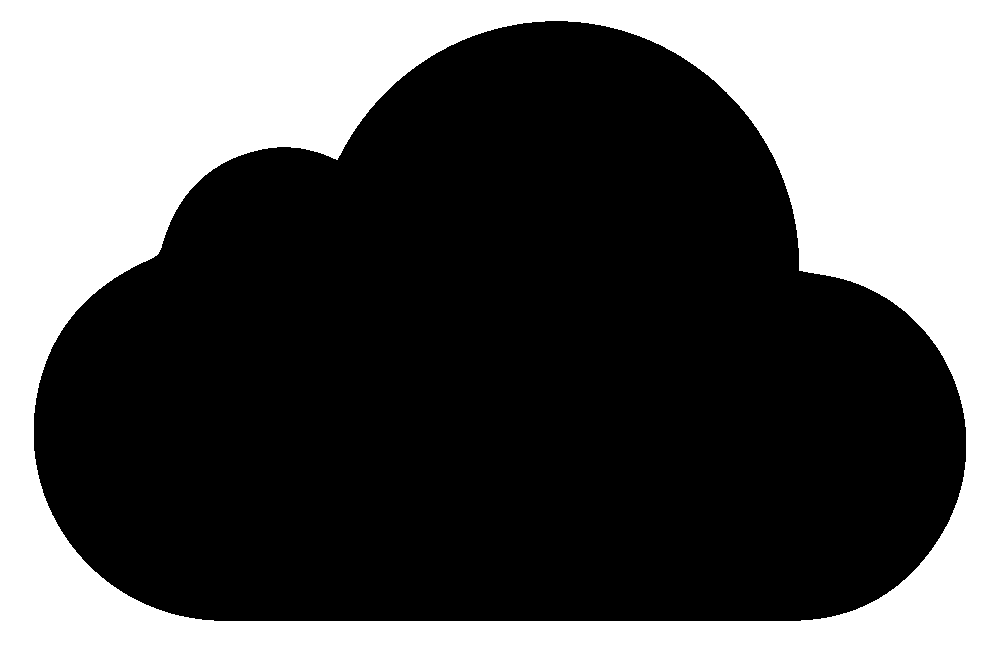

In [103]:
# Tampilkan masking
from google.colab.patches import cv2_imshow

cv2_imshow(cloud_mask)

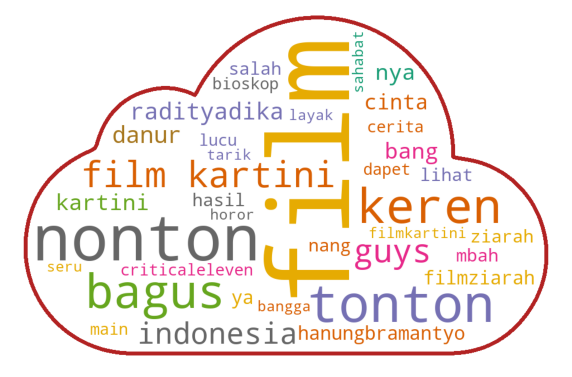

In [104]:
# WordCloud Label Sentimen Positive

sentimen_positive = dataset_sentimen[dataset_sentimen.label == 1]
positive_string = []

for t in sentimen_positive.text_tweet_bersih:
  positive_string.append(t)

string = pd.Series(positive_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800, margin=10,
                      background_color='white', colormap='Dark2',
                      max_font_size=200, min_font_size=25,
                      mask=cloud_mask, contour_width=10, contour_color='firebrick',
                      max_words=100).generate(string)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

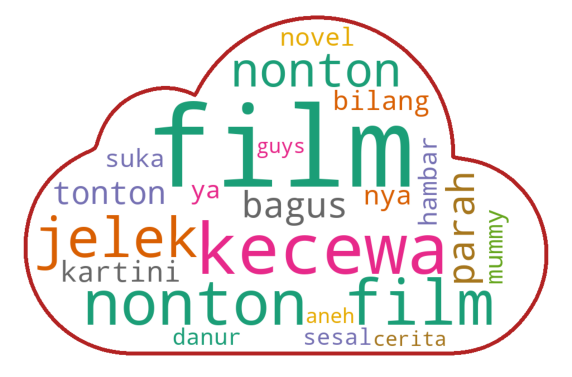

In [105]:
# WordCloud Label Sentimen negative

sentimen_negative = dataset_sentimen[dataset_sentimen.label == -1]
negative_string = []

for t in sentimen_negative.text_tweet_bersih:
  negative_string.append(t)

string = pd.Series(negative_string).str.cat(sep=' ')

wordcloud = WordCloud(width=1600, height=800, margin=10,
                      background_color='white', colormap='Dark2',
                      max_font_size=200, min_font_size=25,
                      mask=cloud_mask, contour_width=10, contour_color='firebrick',
                      max_words=100).generate(string)
plt.figure(figsize=(10,8))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()